## Analysis Notebook 1: Microscope Calibration

must do this first before analyzing any DNAntenna/origami data. your optical setup and camera is likely different from ours, so this calibration will make things easier to troubleshoot downstream. the following notebook uses tetraspeck beads (invitrogen) for calibration of the 638 nm laser (same principles can be applied for other lasers). this notebook covers experimental localization precision (ADD:TIRF DECAY). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from IPython.display import display, Image
import ipympl
import csv
import sys
import os

In [12]:
# find peaks in raw data
sys.path.append('D:/ltakiguchi/DNAntenna-dev/sma/') # path to folder with sma code
from ffptif import ffp_tif
from tr2csv import tr_2csv

analysisPath = 'D:/ltakiguchi/DNAntenna-main/DATA/20230719_koolance_beads/1000hz/' # folder containing tif
xmlName = 'Analysis_Settings' # xml file with adjustable parameters
analysisName = '100laser638_0004' # tif file name
xmlFilename = analysisPath + xmlName
filename = analysisPath + analysisName
ffp_tif(filename, xmlFilename)

ffptif started at 2023-11-14 08:42:52 on file: D:/ltakiguchi/DNAntenna-main/DATA/20230719_koolance_beads/1000hz/100laser638_0004
x pixels: 1152. y pixels: 144 r 64
xcrop: 1152. ycrop: 128 for bk size 64
number sets: 1
working on 0
frame: 0 at 2023-11-14 08:42:53 -- no_good = 193. no_keep = 252
based on intensity, keeping 193 out of 193 spots
there were 193 events
average event length: 100.000000
median event length: 100.000000
done at 2023-11-14 08:42:54
automatically calling aptif
apdax started at 2023-11-14 08:42:54 on file: D:/ltakiguchi/DNAntenna-main/DATA/20230719_koolance_beads/1000hz/100laser638_0004
ignoring bounds from peak picking...
193  events were found in file (after filtering, if applicable)
working on : 0 1999at 2023-11-14 08:42:54
working on : 1000 1999at 2023-11-14 08:45:37
saving complete .trdir at 2023-11-14 08:48:24
number of peaks: 193
Generating 2D histograms starting at 2023-11-14 08:48:25on D:/ltakiguchi/DNAntenna-main/DATA/20230719_koolance_beads/1000hz/100las

In [13]:
newpath = filename+'trcsv' # makes trcsv folder of fitted peaks
if not os.path.exists(newpath):
    os.makedirs(newpath) # makes a new folder in with same name as filename but ending in trcsv
tr_2csv(filename) # generates .csv files from .tr files 

**!!!!!! first set path to a folder of fitted bead data with same acquisition frame rate and laser intensity !!!!!!** then iterate through each folder ending with trcsv to extract mean intensity and corresponding standard deviation of position from each .csv. output gives stdev in nm

In [27]:
main_folder_path = 'D:/ltakiguchi/DNAntenna-main/DATA/20230719_koolance_beads/1000hz/638/' 
save_figs = 1 # 1 = saves plots to folder, 0 = doesn't save plots

In [28]:
# analysis of all trcsv folders in specified path
subfolders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f)) and f.endswith('trcsv')]
dfs = []  # initialize list to store dataframes

for subfolder in subfolders: # iterates thru folder specified in main_folder_path
    folder_path = os.path.join(main_folder_path, subfolder)
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')] # list of csvs in subfolder

    for file in csv_files: # iterates through all csvs
        file_path = os.path.join(folder_path, file)
        
        pixel_size = 108 # nm
        data_raw = pd.read_csv(file_path,names=['xx','yy','c0int','fitheight','noise','SNR'])
        data_raw = data_raw[(data_raw['xx'] != 0) & (data_raw['yy'] != 0)] # drop zero values from dataframe
        data_raw['xpos_nm'] = data_raw['xx']*pixel_size
        data_raw['ypos_nm'] = data_raw['yy']*pixel_size
        data_crop = data_raw.head(-100) # how many frames to crop dataframe by from end (head(10) removes last 10 frames)
        data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
        
        # calculate the mean of the intensity column for the current csv file
        avg_intensity = data_crop['c0int'].mean()
        std_dev = data_crop['total_pos'].std()
        # create dataframe for current csv file
        file_df = pd.DataFrame({
            'Folder': [subfolder],
            'Filename': [file],
            'Average c0int': [avg_intensity],
            'Std Dev (nm)': [std_dev]
        })
        # appends dataframe to the list
        dfs.append(file_df)

results_df = pd.concat(dfs, ignore_index=True) # concatenates all dataframes in the list into a single dataframe
n = len(results_df) # number of beads in analysis
print(results_df)

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

                    Folder   Filename  Average c0int  Std Dev (nm)
0    100laser638_0002trcsv  00000.csv     733.825263     21.005844
1    100laser638_0002trcsv  00001.csv    1284.997368     14.323440
2    100laser638_0002trcsv  00002.csv    1139.880526     14.305330
3    100laser638_0002trcsv  00003.csv     861.824737     19.222686
4    100laser638_0002trcsv  00004.csv    1177.580000     14.563090
..                     ...        ...            ...           ...
389  100laser638_0004trcsv  00188.csv    6555.207368      9.602382
390  100laser638_0004trcsv  00189.csv    5925.024211      8.271065
391  100laser638_0004trcsv  00190.csv    1058.687895     19.919118
392  100laser638_0004trcsv  00191.csv    3524.737368     10.006928
393  100laser638_0004trcsv  00192.csv    3196.571053     10.645905

[394 rows x 4 columns]


C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop['total_pos'] = np.sqrt(data_crop['xpos_nm']**2 + data_crop['ypos_nm']**2)
C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\3536461800.py:18: SettingWithCopyWarnin

In [18]:
# sigma(localizations) = k*1/sqrt(intensity) - simplified form from Wang et al. 2014 and Thompson et al. 2002
# assumptions: small pixel size (gets rid of 2nd term), negligible background (gets rid of 3rd term)

def sigmaIntensity_fit(x, k, c):
    return k / np.sqrt(x) + c # c is some fitting constant

x = results_df['Average c0int']
y = results_df['Std Dev (nm)']
valid_indices = np.logical_and(~np.isnan(x), x != 0) #  filters out NaN and 0 values
x_filtered = x[valid_indices]
y_filtered = y[valid_indices]
popt, pcov = curve_fit(sigmaIntensity_fit, x_filtered, y_filtered, p0=[1, 0])

x_fit = np.linspace(0, 8000, 100).astype(float)
y_fit = sigmaIntensity_fit(x_fit, *popt)
residuals = y_filtered - sigmaIntensity_fit(x_filtered, *popt)

C:\Users\ltakiguchi.AD\AppData\Local\Temp\ipykernel_171200\2248200463.py:5: RuntimeWarning: divide by zero encountered in divide
  return k / np.sqrt(x) + c # c is some fitting constant


<IPython.core.display.Javascript object>


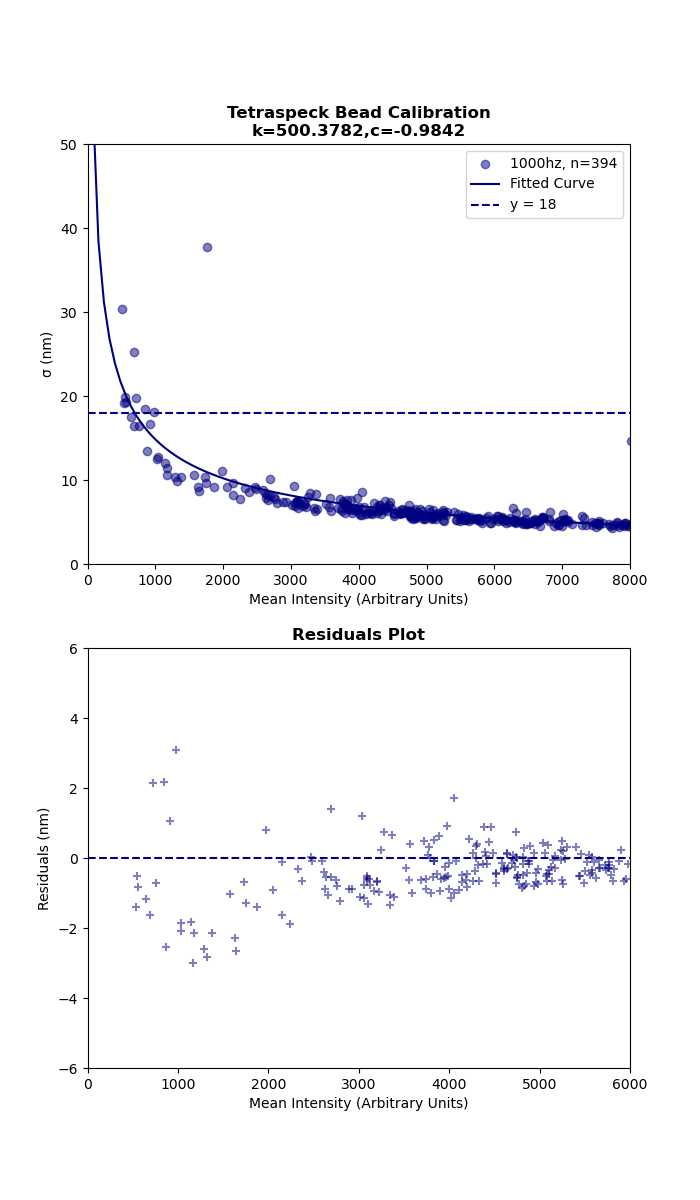

In [29]:
%matplotlib notebook

fig, ax = plt.subplots(2,1, figsize=(7,12))
ax[0].scatter(x, y, marker='o', c='navy',alpha=0.5, label=f'1000hz, n={n}')
ax[0].plot(x_fit, y_fit, c='navy', label='Fitted Curve')
ax[0].set_xlabel('Mean Intensity (Arbitrary Units)')
ax[0].set_ylabel('\u03C3 (nm)') #sigma = std dev
ax[0].set_title(f'Tetraspeck Bead Calibration\nk={popt[0]:.4f},c={popt[1]:.4f}',fontweight='bold')
ax[0].set_xlim([0,8000])
ax[0].set_ylim([0,50])
ax[0].axhline(y=18, color='navy', linestyle='--',label='y = 18')
ax[0].legend()

ax[1].scatter(x, residuals, marker='+',alpha=0.5, c='navy')
ax[1].axhline(y=0, color='navy', linestyle='--')
ax[1].set_xlabel('Mean Intensity (Arbitrary Units)')
ax[1].set_xlim([0,6000])
ax[1].set_ylim([-6,6])
ax[1].set_ylabel('Residuals (nm)')
ax[1].set_title('Residuals Plot',fontweight='bold')
plt.show()
if save_figs:
    fig1 = f'{main_folder_path}calib_curve.png'
    plt.savefig(fig1)

<IPython.core.display.Javascript object>


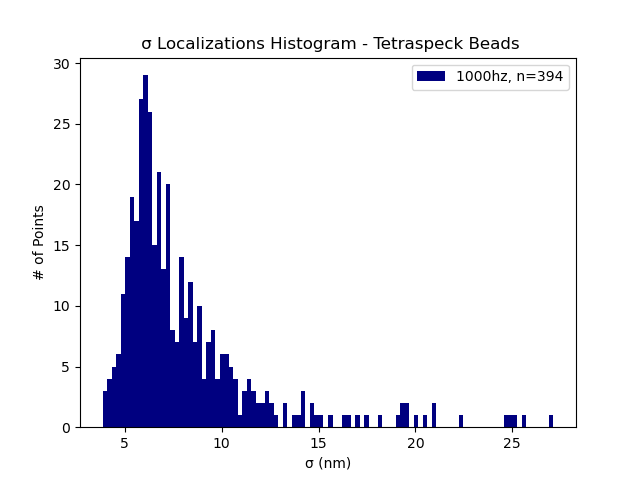

In [30]:
fig, ax = plt.subplots()
ax.hist(results_df['Std Dev (nm)'],bins=100,color='navy',label=f'1000hz, n={n}')

ax.set_xlabel('\u03C3 (nm)')
ax.set_ylabel('# of Points')
ax.set_title(' \u03C3 Localizations Histogram - Tetraspeck Beads')
ax.legend()
plt.show()
if save_figs:
    fig1 = f'{main_folder_path}calib_hist.png'
    plt.savefig(fig1)